In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [4]:
try: 
  %tensorflow 2.x
except:
  pass

In [5]:
import json
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [6]:
DATASET_NAME = "sarcasm.json"
BASE_URL = "https://storage.googleapis.com/laurencemoroney-blog.appspot.com"
path_pwd = !pwd
BASE_PATH = os.path.join(path_pwd[0], 'datasets')

In [7]:
!mkdir -p $BASE_PATH
print(BASE_PATH)

/home/laura/data/nlp_in_tensorflow/week_3_sequence_models/datasets


In [8]:
full_url = os.path.join(BASE_URL, DATASET_NAME)
dataset_path = os.path.join(BASE_PATH, DATASET_NAME)

In [9]:
# Download dataset
!wget --no-check-certificate $full_url -O $dataset_path

--2019-12-09 20:55:49--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.193.128, 2a00:1450:400b:c01::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/home/laura/data/nlp_in_tensorflow/week_3_sequence_models/datasets/sarcasm.json’

/home/laura/data/nl 100%[===================>]   5.38M  17.6MB/s    in 0.3s    

2019-12-09 20:55:50 (17.6 MB/s) - ‘/home/laura/data/nlp_in_tensorflow/week_3_sequence_models/datasets/sarcasm.json’ saved [5643545/5643545]



In [10]:
# Define params 
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [11]:
# Open the file and read it
with open(dataset_path, 'r') as f:
    datastore = json.load(f)

In [12]:
sentences = []
labels = []

# Split into the headline and the label
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [13]:
# Split the dataset between training and testing 
training_sentences, training_labels = sentences[0:training_size], np.array(labels[0:training_size])
testing_sentences, testing_labels = sentences[training_size:], np.array(labels[training_size:])

In [14]:
# Create the tokenizer with vocab size 1000
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

In [15]:
# Generate the tokens for the words in training 
tokenizer.fit_on_texts(training_sentences)

# Get the word index
word_index = tokenizer.word_index

In [16]:
# Generate the sequences
training_sequences = tokenizer.texts_to_sequences(training_sentences)
# Add the padding to sequences using post
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [17]:
# Generate sequences for testing sentences and its padding 
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [18]:
# Create the model using LSTM Bidirectional 
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [19]:
# Configure the model 
metric = 'accuracy' 
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=[metric])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           16000     
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                12544     
_________________________________________________________________
dense (Dense)                (None, 24)                1560      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 30,129
Trainable params: 30,129
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Train the model 
num_epochs = 30
history = model.fit(training_padded, training_labels, 
                    epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels), 
                    verbose=1)

Train on 20000 samples, validate on 6709 samples
Epoch 1/30
20000/20000 [==============================] - 18s 893us/sample - loss: 0.4543 - accuracy: 0.7695 - val_loss: 0.3910 - val_accuracy: 0.8213
Epoch 2/30
20000/20000 [==============================] - 13s 668us/sample - loss: 0.3572 - accuracy: 0.8364 - val_loss: 0.3781 - val_accuracy: 0.8284
Epoch 3/30
20000/20000 [==============================] - 12s 593us/sample - loss: 0.3308 - accuracy: 0.8507 - val_loss: 0.3712 - val_accuracy: 0.8275
Epoch 4/30
20000/20000 [==============================] - 12s 619us/sample - loss: 0.3111 - accuracy: 0.8636 - val_loss: 0.3691 - val_accuracy: 0.8335
Epoch 5/30
20000/20000 [==============================] - 12s 584us/sample - loss: 0.2983 - accuracy: 0.8686 - val_loss: 0.3766 - val_accuracy: 0.8296
Epoch 6/30
20000/20000 [==============================] - 11s 542us/sample - loss: 0.2899 - accuracy: 0.8739 - val_loss: 0.3815 - val_accuracy: 0.8268
Epoch 7/30
20000/20000 [=====================

In [21]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

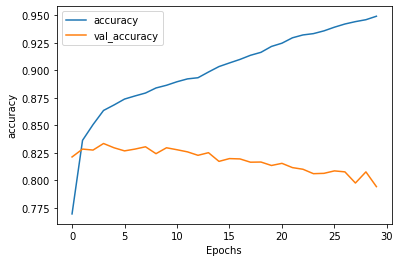

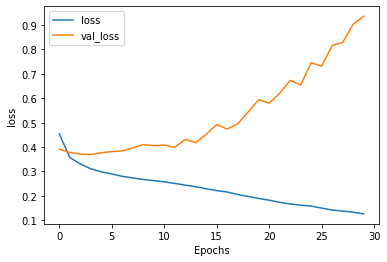

In [22]:
plot_graphs(history, metric)
plot_graphs(history, 'loss')

In [23]:
path_to_save_model = os.path.join(BASE_PATH, "sarcasm_lstm.h5")
model.save(path_to_save_model)

In [24]:
session.close()